##Chapter 4 - Spam Detection of Chicago Yelp Reviews
###Part 3: Handling Class Inbalance with GATv2

This code serves to demonstrate and compare two Graph Attention Network (GAT) architectures in PyG for the task of spam detection using the YelpChi dataset, which contains reviews of restaurants and hotels in Chicago.

This notebook is the second part of an analysis that did EDA on the node features of this dataset and conducted baselines models using logistic regression, XGBoost, and an MLP. This notebook uses GCN as an additional baseline model.

The procedure can be broken down into the following steps:

1. **Data Preparation**: Same as in part 2.

2. **Graph Analysis**: Same as in part 2, additional analysis is done to assess the distribution of degrees among nodes. This is needed for methods that generate synthetic nodes; for such nodes, the generated edges should be consistent with those of ordinary nodes.

3. **Model Training (GATv2)**: The code extends the comparison by training a GATv2 model, a variation of GAT that potentially offers improved performance. It again tracks loss, AUC, and ROC curves during training.



##Setup the environment

In [ ]:
# Find the CUDA version PyTorch was installed with
!python -c "import torch; print(torch.version.cuda)"

12.1


In [ ]:
# PyTorch version
!python -c "import torch; print(torch.__version__)"

2.3.0+cu121


In [ ]:
# Use the above information to fill in the http address below
%%capture
!pip install ogb pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install torch-geometric



In [ ]:
!pip install torchsampler
!pip install torch-geometric imbalanced-learn

# https://imbalanced-learn.org/stable/install.html

In [ ]:
import torch
import pickle
import random as rd
import random
import numpy as np
import scipy.sparse as sp
from scipy.io import loadmat
import copy as cp
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, average_precision_score
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter


from sklearn.model_selection import train_test_split

from torch_geometric.nn import GATConv
import torch.nn as nn
from torch_geometric.loader import NeighborLoader, ImbalancedSampler, DataLoader
from torch_geometric.nn import GCNConv, Linear
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import ToUndirected, RandomNodeSplit
from torch_geometric.utils import from_networkx, to_networkx
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import GATv2Conv, BatchNorm
import torch.utils.checkpoint as checkpoint
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.data import Data, DataLoader
from torch_geometric.sampler import NeighborSampler
from torchsampler import ImbalancedDatasetSampler



def sparse_to_adjlist(sp_matrix, filename):
	"""
	Transfer sparse matrix to adjacency list
	:param sp_matrix: the sparse matrix
	:param filename: the filename of adjlist
	"""
	# add self loop
	homo_adj = sp_matrix + sp.eye(sp_matrix.shape[0])
	# create adj_list
	adj_lists = defaultdict(set)
	edges = homo_adj.nonzero()
	for index, node in enumerate(edges[0]):
		adj_lists[node].add(edges[1][index])
		adj_lists[edges[1][index]].add(node)
	with open(filename, 'wb') as file:
		pickle.dump(adj_lists, file)
	file.close()

##Load and process the dataset.

For this problem, the dataset can be found in the repo in a zipped file. Upload this file into the local directory, and copy the path into the cell below. If uploaded into the top folder, the path below should suffice.

In [ ]:
# Note, when uploading your file to colab, you may need to restart the instance for this cell to work.
!unzip '/content/YelpChi.zip'

# /content/YelpChi.zip


Archive:  /content/YelpChi.zip
  inflating: yelp_homo_adjlists.pickle  
  inflating: yelp_rsr_adjlists.pickle  
  inflating: yelp_rtr_adjlists.pickle  
  inflating: yelp_rur_adjlists.pickle  
  inflating: YelpChi.mat             
  inflating: __MACOSX/._YelpChi.mat  


In [ ]:
# (COLAB) Upload the YelpChi.mat file into the session directory, then copy
#         the path into the 'prefix' variable

prefix = '/content/'

data_file = loadmat(prefix +  'YelpChi.mat')

labels = data_file['label'].flatten()
features = data_file['features'].todense().A

yelp_homo = data_file['homo'] #C
sparse_to_adjlist(yelp_homo, prefix + 'yelp_homo_adjlists.pickle') #C



# load the preprocessed adj_lists
with open(prefix + 'yelp_homo_adjlists.pickle', 'rb') as file:
    homogenous = pickle.load(file)
file.close()


Below, we compute various graph-related metrics such as the number of nodes, edges, density, diameter, and connected components.

I have commented out parts of the exploration that run for more than 10 minutes.

In [ ]:
g = nx.Graph(homogenous)

# g = H
print(f'Number of nodes: {g.number_of_nodes()}')
print(f'Number of edges: {g.number_of_edges()}')
print(f'Average node degree: {len(g.edges) / len(g.nodes):.2f}')


Number of nodes: 45954
Number of edges: 3892933
Average node degree: 84.71


The graph data is converted into a format suitable for PyTorch Geometric. This involves converting the graph into a torch geometric data object and normalizing the features.


In [ ]:
# Calculate node degrees
degrees = [deg for node, deg in g.degree()]

# Print basic statistics
print(f'Number of nodes: {g.number_of_nodes()}')
print(f'Number of edges: {g.number_of_edges()}')


Number of nodes: 45954
Number of edges: 3892933


In [ ]:
# Additional metrics
# Density
density = nx.density(g)
print(f'Density: {density:.2f}')

# Diameter (only for connected graphs)
if nx.is_connected(g):
    diameter = nx.diameter(g)
    print(f'Diameter: {diameter}')
else:
    print('The graph is not connected.')

# Average Clustering Coefficient (commented out; it will take a while)
# avg_cluster = nx.average_clustering(g)
# print(f'Average Clustering Coefficient: {avg_cluster:.2f}')

# Connected Components
connected_comp = nx.number_connected_components(g)
print(f'Number of connected components: {connected_comp}')

# Degree distribution (just showing the first few as an example)
degree_dist = [deg for node, deg in g.degree()]
print(f'Degree distribution (first 10 nodes): {degree_dist[:100]}')

# Centrality measure example: Betweenness centrality for top 5 nodes
# Commented out; it will take a while
# betweenness = nx.betweenness_centrality(g)
# sorted_betw = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
# print(f'Top 5 nodes by betweenness centrality: {sorted_betw[:5]}')

# Cycle detection
cycles = nx.cycle_basis(g)
print(f'Number of cycles detected: {len(cycles)}')

Density: 0.00
The graph is not connected.
Number of connected components: 26
Degree distribution (first 10 nodes): [4, 4, 4, 3, 4, 5, 5, 6, 5, 19, 18, 18, 13, 18, 17, 17, 18, 16, 17, 19, 18, 18, 17, 16, 16, 18, 13, 12, 14, 20, 13, 15, 15, 13, 14, 17, 16, 14, 14, 16, 14, 12, 13, 11, 14, 20, 16, 18, 21, 19, 16, 20, 19, 20, 18, 18, 16, 19, 51, 52, 49, 51, 49, 50, 48, 46, 58, 58, 58, 47, 50, 26, 67, 52, 66, 41, 64, 48, 43, 41, 49, 49, 48, 50, 46, 43, 48, 49, 43, 47, 49, 48, 44, 53, 46, 49, 49, 49, 48, 48]
Number of cycles detected: 3847005


In [ ]:
if not nx.is_connected(g):
    # Identify connected components
    components = list(nx.connected_components(g))

    # Print number of components
    print(f'The graph has {len(components)} connected components.')

    for idx, component in enumerate(components, 1):
        # Extract the subgraph for this component
        subgraph = g.subgraph(component)

        # Display basic properties for this component
        print(f'\nComponent {idx}:')
        print(f'  - Number of nodes: {subgraph.number_of_nodes()}')
        print(f'  - Number of edges: {subgraph.number_of_edges()}')
        avg_degree = sum(dict(subgraph.degree()).values()) / subgraph.number_of_nodes()
        print(f'  - Average node degree: {avg_degree:.2f}')
        density = nx.density(subgraph)
        print(f'  - Density: {density:.2f}')
        # Average clustering commented out for long running time
        # avg_clustering = nx.average_clustering(subgraph)
        # print(f'  - Average clustering coefficient: {avg_clustering:.2f}')

        # You can add more properties as per your interest

else:
    print("The graph is connected.")

The graph has 26 connected components.

Component 1:
  - Number of nodes: 3
  - Number of edges: 6
  - Average node degree: 4.00
  - Density: 2.00

Component 2:
  - Number of nodes: 6
  - Number of edges: 14
  - Average node degree: 4.67
  - Density: 0.93

Component 3:
  - Number of nodes: 45900
  - Number of edges: 3892810
  - Average node degree: 169.62
  - Density: 0.00

Component 4:
  - Number of nodes: 13
  - Number of edges: 60
  - Average node degree: 9.23
  - Density: 0.77

Component 5:
  - Number of nodes: 2
  - Number of edges: 3
  - Average node degree: 3.00
  - Density: 3.00

Component 6:
  - Number of nodes: 2
  - Number of edges: 3
  - Average node degree: 3.00
  - Density: 3.00

Component 7:
  - Number of nodes: 1
  - Number of edges: 1
  - Average node degree: 2.00
  - Density: 0.00

Component 8:
  - Number of nodes: 2
  - Number of edges: 3
  - Average node degree: 3.00
  - Density: 3.00

Component 9:
  - Number of nodes: 2
  - Number of edges: 3
  - Average node degre

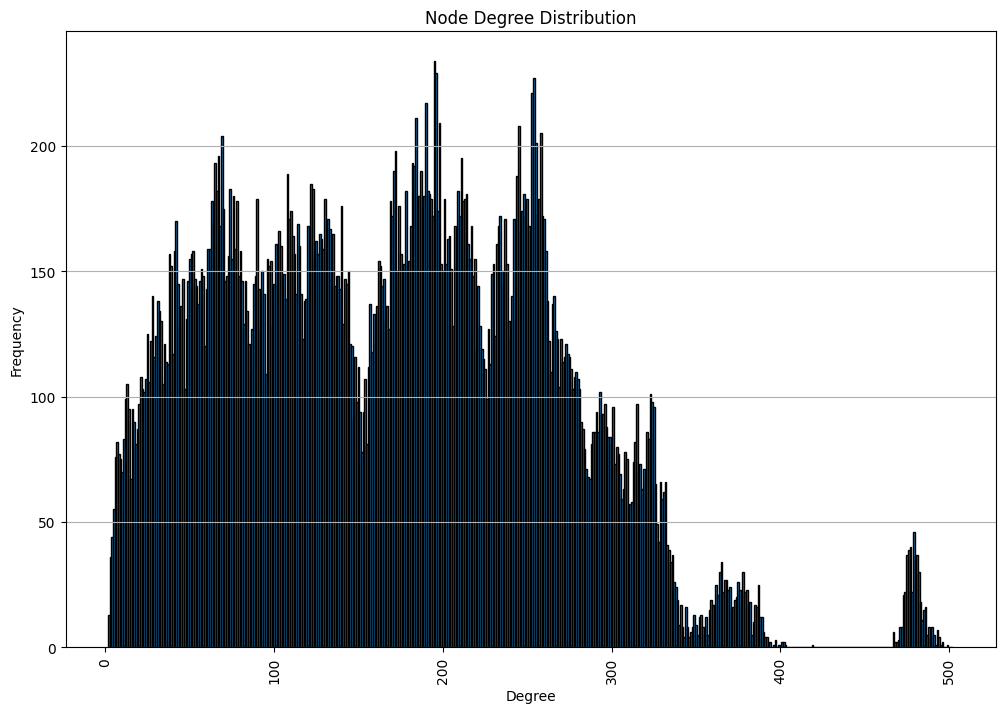

In [ ]:
# Plot degree distribution
plt.figure(figsize=(12, 8))
plt.hist(degrees, bins=np.arange(min(degrees), max(degrees) + 1) - 0.5, edgecolor='black')
plt.title('Node Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y')
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##Training and Evaluation of GATv2 Model
A GATv2 model is defined as a PyTorch neural network module. It consists of two GATv2 layers with batch normalization. The GATv2 model is trained using the defined model, loss function, and optimizer. Training metrics such as loss and AUC score are displayed.  The final GATv2 model is evaluated, and its accuracy is displayed. ROC curve data is computed and plotted alongside other models.


GATv2Conv —> https://arxiv.org/pdf/2105.14491.pdf

In [ ]:
def verify_class_distribution(y, label=""):
    unique, counts = np.unique(y, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    print(f"Class distribution {label}: {class_distribution}")
    return class_distribution


def plot_feature_distribution(X, y, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_result = tsne.fit_transform(pca_result)

    plt.figure(figsize=(16, 10))
    sns.scatterplot(
        x=tsne_result[:,0], y=tsne_result[:,1],
        hue=y,
        palette=sns.color_palette("hsv", 2),
        legend="full",
        alpha=0.3
    ).set(title=title)
    plt.show()

class GATv2Enhanced(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=88, num_heads=8, dropout_p=0.15, num_layers=4):
        super(GATv2Enhanced, self).__init__()
        self.num_layers = num_layers
        self.dropout_p = dropout_p
        self.layers = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()

        # Input layer
        self.layers.append(GATConv(num_node_features, hidden_channels, heads=num_heads, dropout=dropout_p))
        self.norms.append(BatchNorm(hidden_channels * num_heads))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=dropout_p))
            self.norms.append(BatchNorm(hidden_channels * num_heads))

        # Output layer
        self.layers.append(GATConv(hidden_channels * num_heads, num_classes, heads=1, concat=True, dropout=dropout_p))
        self.norms.append(BatchNorm(num_classes))

    def forward(self, x, edge_index):
        for i in range(self.num_layers):
            x = self.layers[i](x, edge_index)
            x = self.norms[i](x)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout_p, training=self.training)
        return x  # Removed log_softmax for BCEWithLogitsLoss

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_nodes = 0



    for batch_idx, data in enumerate(loader):
        try:
            data = data.to(device)
            print(f"Processing batch {batch_idx + 1}")
            print(f"Edge index shape: {data.edge_index.shape}")
            print(f"Node features shape: {data.x.shape}")
            print(f"Number of nodes: {data.num_nodes}")

            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask].unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            num_nodes = data.num_nodes
            total_loss += batch_loss * num_nodes
            total_nodes += num_nodes

        except Exception as e:
            print(f"Error processing batch {batch_idx+1}: {str(e)}")
            continue

    if total_nodes == 0:
        return float('inf')  # Avoid division by zero
    average_loss = total_loss / total_nodes
    print(f'Average Training Loss: {average_loss:.4f}')
    return average_loss



def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_nodes = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index)
            preds = torch.sigmoid(out) > 0.5
            probs = torch.sigmoid(out)
            loss = criterion(out, data.y.unsqueeze(1).float())
            total_loss += loss.item() * data.num_nodes
            total_nodes += data.num_nodes

            all_labels.extend(data.y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs), total_loss / total_nodes


In [ ]:
data = from_networkx(g)
data.x = torch.tensor(features).float()
data.y = torch.tensor(labels).long()  # Ensure labels are long tensors for classification
data.num_node_features = data.x.shape[-1]

In [ ]:
data
# Data(edge_index=[2, 7739912], num_nodes=45954, x=[45954, 32], y=[45954], num_node_features=32)


Data(edge_index=[2, 7739912], num_nodes=45954, x=[45954, 32], y=[45954], num_node_features=32)

In [ ]:
node_indices = np.arange(data.num_nodes)
train_indices, temp_indices = train_test_split(node_indices, test_size=0.4, random_state=42, stratify=data.y)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42, stratify=data.y[temp_indices])

train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [ ]:
train_mask.shape, train_indices.shape

(torch.Size([45954]), (27572,))

In [ ]:
from torch_geometric.sampler import BaseSampler, SamplerOutput
import torch

class BalancedNodeSampler(BaseSampler):
    def __init__(self, data, num_samples=None):
        super().__init__()
        self.data = data
        self.num_samples = num_samples  # Optional: define fixed sampling size per class

    def sample_from_nodes(self, index, **kwargs):
        # Assuming 'index' could be specific nodes or ignored depending on use-case
        majority_indices = torch.where(self.data.y == 0)[0]
        minority_indices = torch.where(self.data.y == 1)[0]

        if self.num_samples is None:
            batch_size = min(len(majority_indices), len(minority_indices))
        else:
            batch_size = self.num_samples // 2

        print(f"Batch size: {batch_size}")

        majority_sample = majority_indices[torch.randperm(len(majority_indices))[:batch_size]]
        minority_sample = minority_indices[torch.randint(len(minority_indices), (batch_size,))]
        batch_indices = torch.cat((majority_sample, minority_sample))

        # Extract subgraph defined by `batch_indices`
        mask = torch.zeros(self.data.num_nodes, dtype=torch.bool)
        mask[batch_indices] = True
        row, col = self.data.edge_index
        mask_edges = mask[row] & mask[col]
        sub_row = row[mask_edges]
        sub_col = col[mask_edges]

        # Re-index nodes to 0...N-1 for the subgraph
        new_index = torch.full((self.data.num_nodes,), -1, dtype=torch.long)
        new_index[batch_indices] = torch.arange(batch_indices.size(0))
        sub_row = new_index[sub_row]
        sub_col = new_index[sub_col]

        return SamplerOutput(
            node=batch_indices,
            row=sub_row,
            col=sub_col,
            edge=None,  # Only provide if you have edge attributes to sample
            num_sampled_nodes=[len(batch_indices)],  # Example of metadata
            metadata=(batch_indices, None)
        )

# Setup the NodeLoader with the custom sampler
sampler = BalancedNodeSampler(data)


from torch_geometric.loader import NodeLoader

batch_of_4 = 27572/4

# Setup the NodeLoader with proper filtering function
loader = NodeLoader(
    data=data,
    node_sampler=BalancedNodeSampler(data, int(batch_of_4)),
    batch_size=100,
    shuffle=True
    # filter_fn=custom_filter_fn,  # Assign the custom filter function
)

# Testing the loader
for step, batch_data in enumerate(loader):
    print(f"Step {step + 1}:")
    print("Batch size:", batch_data.num_nodes)
    print("Class distribution:", batch_data.y.unique(return_counts=True))
    if step >= 3:  # Limiting for demonstration
        break


# Setup the NodeLoaders for training, validation, and testing
train_loader = NodeLoader(
    data=data,
    node_sampler=sampler,
    batch_size=int(batch_of_4),
    shuffle=True,
    input_nodes=train_mask)  # Use train mask to filter nodes for training

# Testing the train loader setup
print("Training Batches:")
for step, batch_data in enumerate(train_loader):
    print(f"Step {step + 1}:")
    print("Batch size:", batch_data.num_nodes)
    print("Class distribution:", batch_data.y.unique(return_counts=True))
    if step >= 3:  # Limiting for demonstration
        break


Batch size: 3446
Step 1:
Batch size: 6892
Class distribution: (tensor([0, 1]), tensor([3446, 3446]))
Batch size: 3446
Step 2:
Batch size: 6892
Class distribution: (tensor([0, 1]), tensor([3446, 3446]))
Batch size: 3446
Step 3:
Batch size: 6892
Class distribution: (tensor([0, 1]), tensor([3446, 3446]))
Batch size: 3446
Step 4:
Batch size: 6892
Class distribution: (tensor([0, 1]), tensor([3446, 3446]))
Training Batches:
Batch size: 6677
Step 1:
Batch size: 13354
Class distribution: (tensor([0, 1]), tensor([6677, 6677]))
Batch size: 6677
Step 2:
Batch size: 13354
Class distribution: (tensor([0, 1]), tensor([6677, 6677]))
Batch size: 6677
Step 3:
Batch size: 13354
Class distribution: (tensor([0, 1]), tensor([6677, 6677]))
Batch size: 6677
Step 4:
Batch size: 13354
Class distribution: (tensor([0, 1]), tensor([6677, 6677]))


In [ ]:
import torch
from torch_geometric.utils import subgraph
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def create_masked_data(data, mask):
    # Get node indices where the mask is True
    node_indices = mask.nonzero(as_tuple=True)[0]

    # Use the PyG subgraph utility to adjust edge indices
    new_edge_index, edge_mask = subgraph(node_indices, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)

    # Create a new Data object with attributes relevant to the subgraph
    new_data = Data(x=data.x[node_indices], edge_index=new_edge_index, y=data.y[node_indices])

    # Copy over any additional edge attributes if necessary
    if 'edge_attr' in data:
        new_data.edge_attr = data.edge_attr[edge_mask]

    return new_data

# Create the data objects for validation and testing
val_data = create_masked_data(data, data.val_mask)
test_data = create_masked_data(data, data.test_mask)

# Create DataLoaders for the new Data objects
val_loader = DataLoader([val_data], batch_size=100, shuffle=False)
test_loader = DataLoader([test_data], batch_size=100, shuffle=False)


print("Validation Batches:")
for step, batch_data in enumerate(val_loader):
    print(f"Step {step + 1}:")
    print("Batch size:", batch_data.num_nodes)
    if hasattr(batch_data, 'y') and batch_data.y is not None:
        print("Class distribution:", batch_data.y.unique(return_counts=True))
    if step >= 3:  # Limiting for demonstration
        break

print("Testing Batches:")
for step, batch_data in enumerate(test_loader):
    print(f"Step {step + 1}:")
    print("Batch size:", batch_data.num_nodes)
    if hasattr(batch_data, 'y') and batch_data.y is not None:
        print("Class distribution:", batch_data.y.unique(return_counts=True))
    if step >= 3:  # Limiting for demonstration
        break



Validation Batches:
Step 1:
Batch size: 9191
Class distribution: (tensor([0, 1]), tensor([7855, 1336]))
Testing Batches:
Step 1:
Batch size: 9191
Class distribution: (tensor([0, 1]), tensor([7856, 1335]))


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
train_mask.shape

torch.Size([45954])

In [ ]:
num_node_features = data.num_node_features
num_classes = 1  # Single output for binary classification
model = GATv2Enhanced(num_node_features, num_classes, hidden_channels=128, num_heads=5, dropout_p=0.9, num_layers=3).to(device)

num_epochs = 1000
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)


def init_weights(m):
    if type(m) == torch.nn.Linear:
        m.weight.data.uniform_(-0.1, 0.1)
        m.bias.data.fill_(0.01)

model.apply(init_weights)  # Apply your chosen initialization function


GATv2Enhanced(
  (layers): ModuleList(
    (0): GATConv(32, 128, heads=5)
    (1): GATConv(640, 128, heads=5)
    (2): GATConv(640, 1, heads=1)
  )
  (norms): ModuleList(
    (0-1): 2 x BatchNorm(640)
    (2): BatchNorm(1)
  )
)

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np

labels = data.y.numpy()

# Configuration
k = 5  # Number of folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# This will be the indices for all nodes since you're working with graph data
node_indices = np.arange(data.num_nodes)


In [ ]:
# Metrics collection for each fold
fold_performance = {
    "train_losses": [],
    "val_losses": [],
    "val_precisions": [],
    "val_recalls": [],
    "val_f1s": [],
    "val_aucs": []
}

# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(node_indices, labels)):
    print(f"Training fold {fold+1}/{k}")

    # Create masks for the current fold
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    train_mask[train_index] = True
    val_mask[val_index] = True

    # Adjust the data object masks for training and validation
    data.train_mask = train_mask
    data.val_mask = val_mask

    # Create dataloaders for the current fold
    train_loader = NodeLoader(data=data, node_sampler=BalancedNodeSampler(data, int(batch_of_4)), batch_size=int(batch_of_4), shuffle=True, input_nodes=train_mask)
    val_loader = NodeLoader(data=data, node_sampler=BalancedNodeSampler(data, int(9191)), batch_size=100, shuffle=False, input_nodes=val_mask)

    # Reinitialize the model and optimizer for each fold
    model = GATv2Enhanced(num_node_features, num_classes, hidden_channels=64, num_heads=4, dropout_p=0.5, num_layers=2).to(device)
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

    # Train and validate the model
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch + 1}/{num_epochs}')
        train_loss = train(model, train_loader, optimizer, criterion)
        val_labels, val_preds, val_probs, val_log_loss = evaluate(model, val_loader, criterion)

        val_precision = precision_score(val_labels, val_preds)
        val_recall = recall_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)
        val_auc = roc_auc_score(val_labels, val_probs)

        fold_performance["train_losses"].append(train_loss)
        fold_performance["val_losses"].append(val_log_loss)
        fold_performance["val_precisions"].append(val_precision)
        fold_performance["val_recalls"].append(val_recall)
        fold_performance["val_f1s"].append(val_f1)
        fold_performance["val_aucs"].append(val_auc)

    # Optionally, process fold results here or save the model
    torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')

# Analyze fold_performance to get mean/std dev of performance metrics across folds


Streaming output truncated to the last 5000 lines.
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 4595
Batch size: 45

In [ ]:
import pandas as pd

# Convert the dictionary of lists into a DataFrame
results_df = pd.DataFrame(fold_performance)

# Calculate mean and standard deviation for each metric
mean_series = results_df.mean()
std_dev_series = results_df.std()

# Print the results
print("Mean Values:\n", mean_series)
print("Standard Deviations:\n", std_dev_series)

Mean Values:
 train_losses      0.535777
val_losses        0.447003
val_precisions    0.891472
val_recalls       0.793455
val_f1s           0.829207
val_aucs          0.916094
dtype: float64
Standard Deviations:
 train_losses      0.006540
val_losses        0.036498
val_precisions    0.059854
val_recalls       0.124078
val_f1s           0.073990
val_aucs          0.002466
dtype: float64
